In [ ]:
# numerical calculation & data frames
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

# statistics
import statsmodels.api as sm

# pandas options
pd.set_option('mode.copy_on_write', True)  # pandas 2.0
pd.options.display.float_format = '{:.2f}'.format  # pd.reset_option('display.float_format')
pd.options.display.max_rows = 7  # max number of rows to display

# NumPy options
np.set_printoptions(precision = 2, suppress=True)  # suppress scientific notation

# For high resolution display
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")

In [ ]:
def rangeplot(df, x, y, color=None):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )


def boxplot(df, x, y, color=None, alpha=0.1):
    return (
        so.Plot(df, x=x, y=y, color=color)
        .add(so.Dots(alpha=alpha, color=".6"), so.Jitter(), so.Dodge())
        .add(so.Range(), so.Est(errorbar=("pi", 50)), so.Dodge())
        .add(so.Dots(pointsize=8, marker="<"), so.Agg("median"), so.Dodge())
        .scale(color="Dark2")
        .theme({**sns.axes_style("whitegrid")})
    )

# flights 데이터 불러오기

In [ ]:
flights = sm.datasets.get_rdataset('flights', 'nycflights13').data

# Make dates from year, month, day
flights["date"] = pd.to_datetime(flights[["year", "month", "day"]])

In [ ]:
daily = flights.groupby("date").size().reset_index(name="n")
daily

,date,n
0,2013-01-01,842
1,2013-01-02,943
2,2013-01-03,914
...,...,...
362,2013-12-29,888
363,2013-12-30,968
364,2013-12-31,776


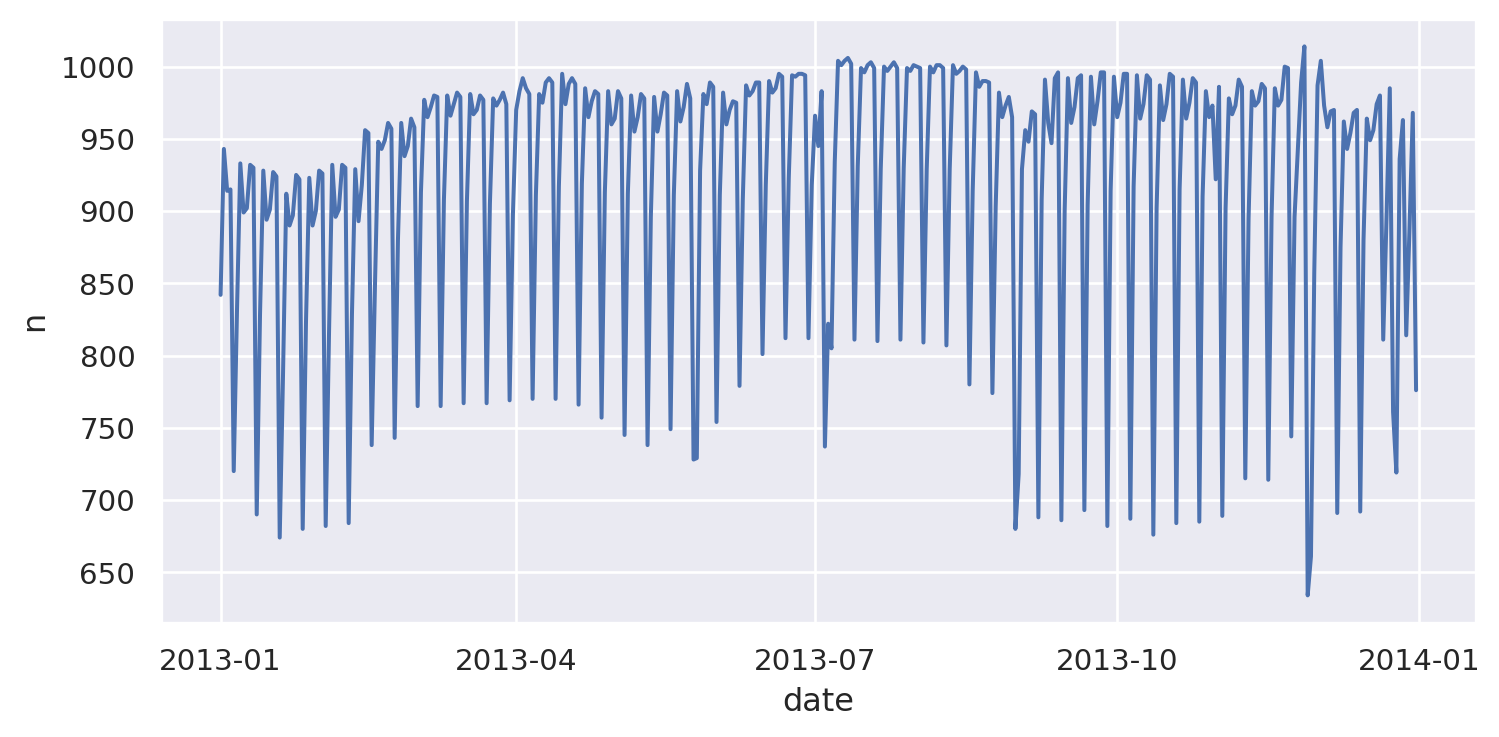

In [ ]:
(
    so.Plot(daily, x='date', y='n')
    .add(so.Line())
    .layout(size=(8, 4))
)

# 요일의 효과를 살펴보기

In [ ]:
# Add a column for the day of the week
daily["wday"] = pd.Categorical(
    daily["date"].dt.day_name().str[:3],
    categories=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    ordered=True,
)

In [ ]:
daily

,date,n,wday
0,2013-01-01,842,Tue
1,2013-01-02,943,Wed
2,2013-01-03,914,Thu
...,...,...,...
362,2013-12-29,888,Sun
363,2013-12-30,968,Mon
364,2013-12-31,776,Tue


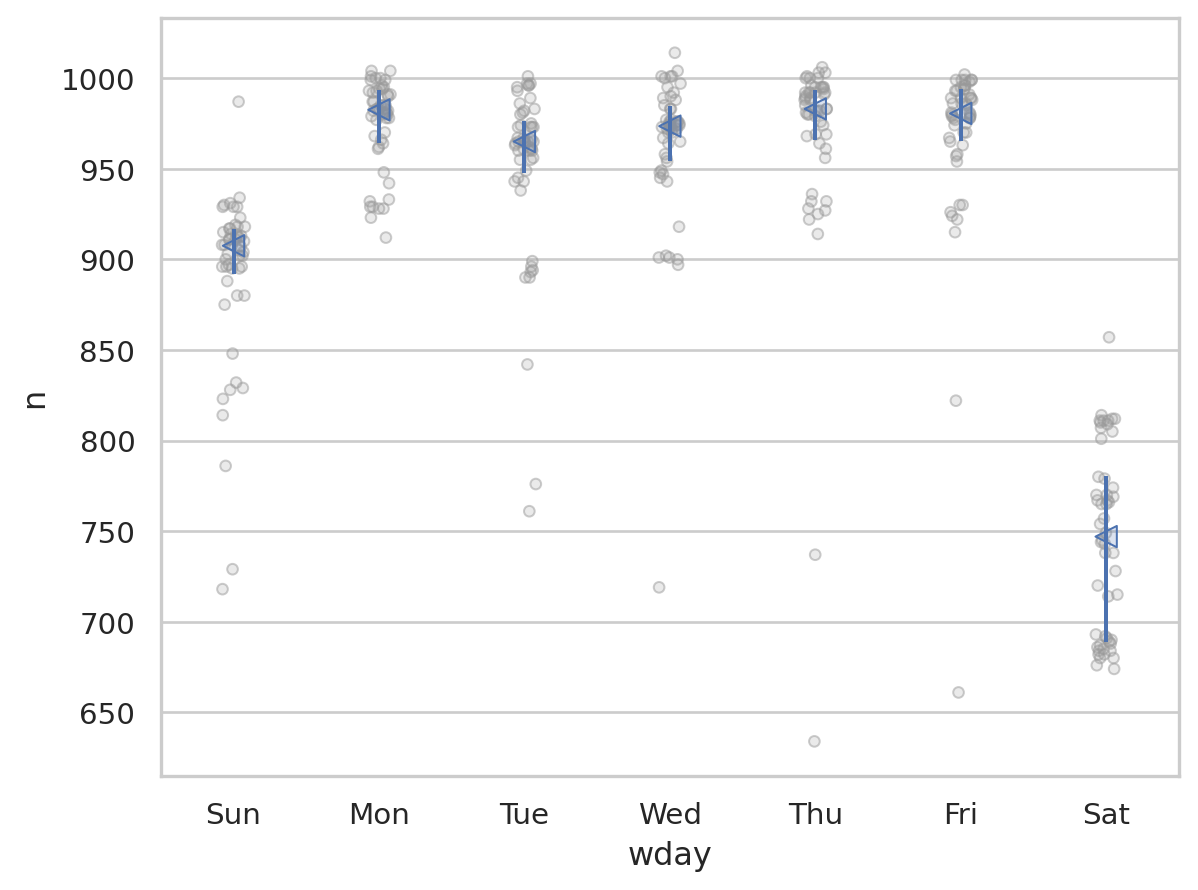

In [ ]:
boxplot(daily, "wday", "n", alpha=.5)

## wday 변수 1개로 OLS 모델 만들기

In [ ]:
import statsmodels.formula.api as smf

mod = smf.ols("n ~ wday", data=daily).fit()
mod.params

Intercept      891.48
wday[T.Mon]     83.33
wday[T.Tue]     59.88
wday[T.Wed]     71.21
wday[T.Thu]     74.27
wday[T.Fri]     75.98
wday[T.Sat]   -146.87
dtype: float64

## gird 만들기

In [ ]:
# Prediction
grid = pd.DataFrame({"wday": ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]})
grid["pred"] = mod.predict(grid)
grid

daily.groupby("wday")["n"].mean()

wday
Sun   891.48
Mon   974.81
Tue   951.36
Wed   962.69
Thu   965.75
Fri   967.46
Sat   744.62
Name: n, dtype: float64

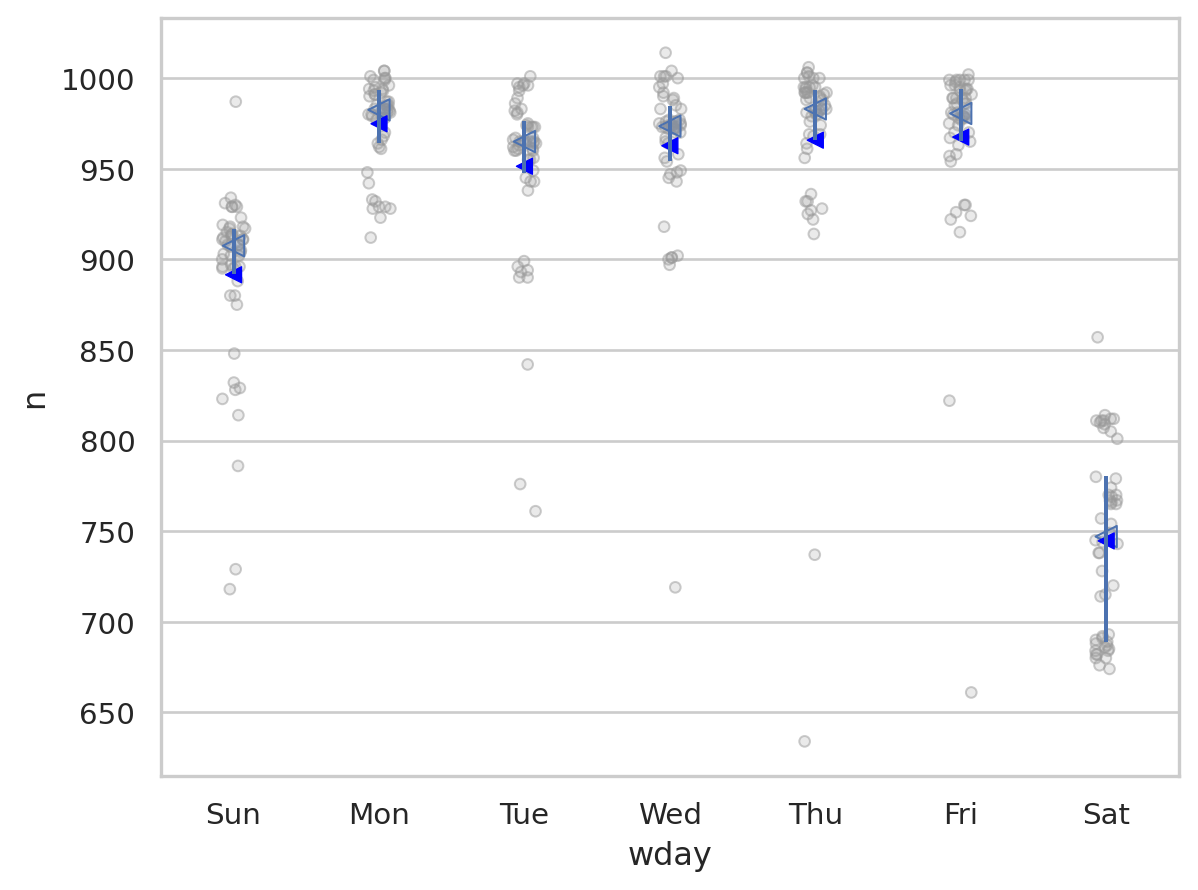

In [ ]:
(
    boxplot(daily, "wday", "n", alpha=.5)
    .add(so.Dot(color="blue", marker="<"), x=grid.wday, y=grid.pred)  # prediction 추가
    .scale(x=so.Nominal(order=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]))
)

## 잔차 보기

In [ ]:
# Add a column of residuals from mod
daily["resid"] = mod.resid

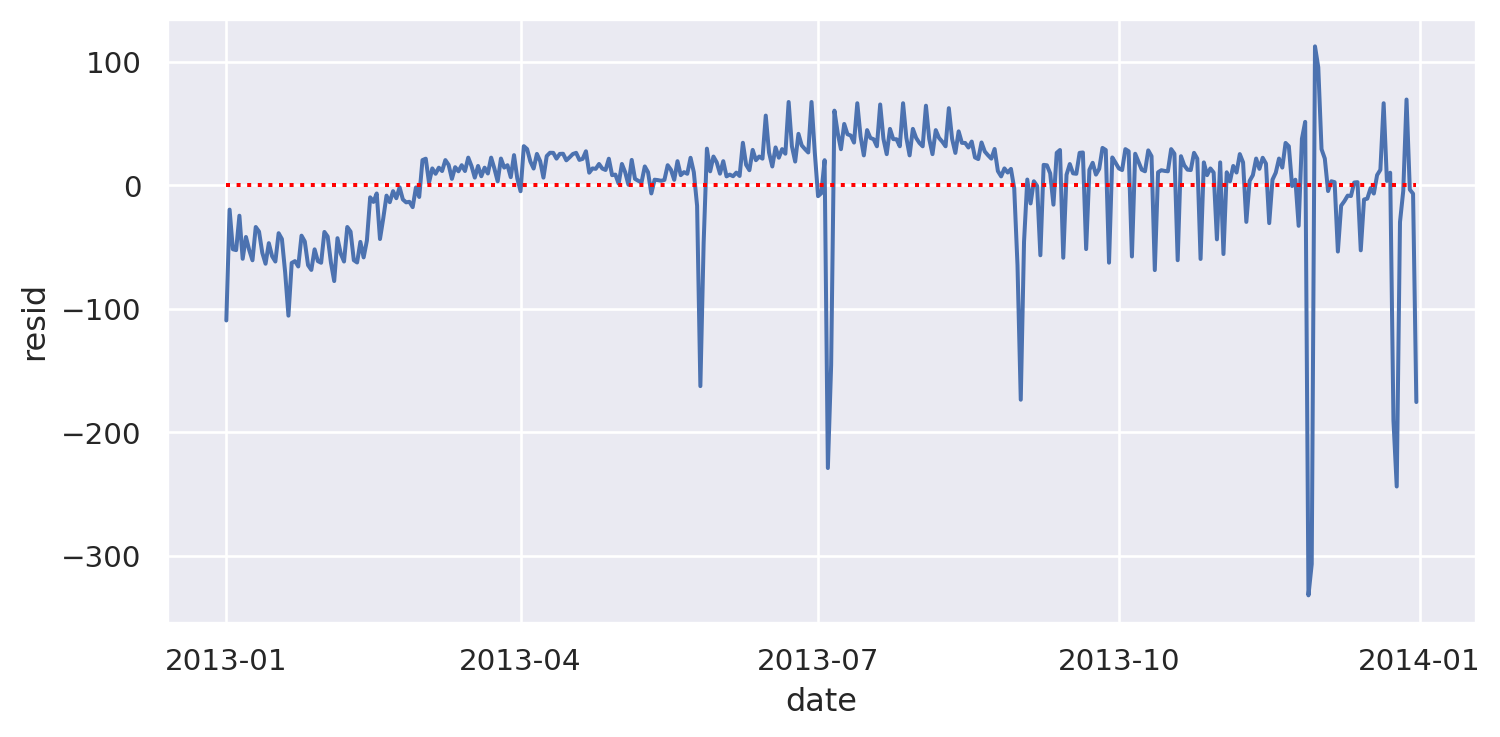

In [ ]:
(
    so.Plot(daily, x='date', y='resid')
    .add(so.Line())
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8, 4))
)

# 요일별 잔차 확인하기
## 6월부터 모델이 잡아내지 못하는 패턴들이 심해져서 이를 위해 요일별 잔차 확인

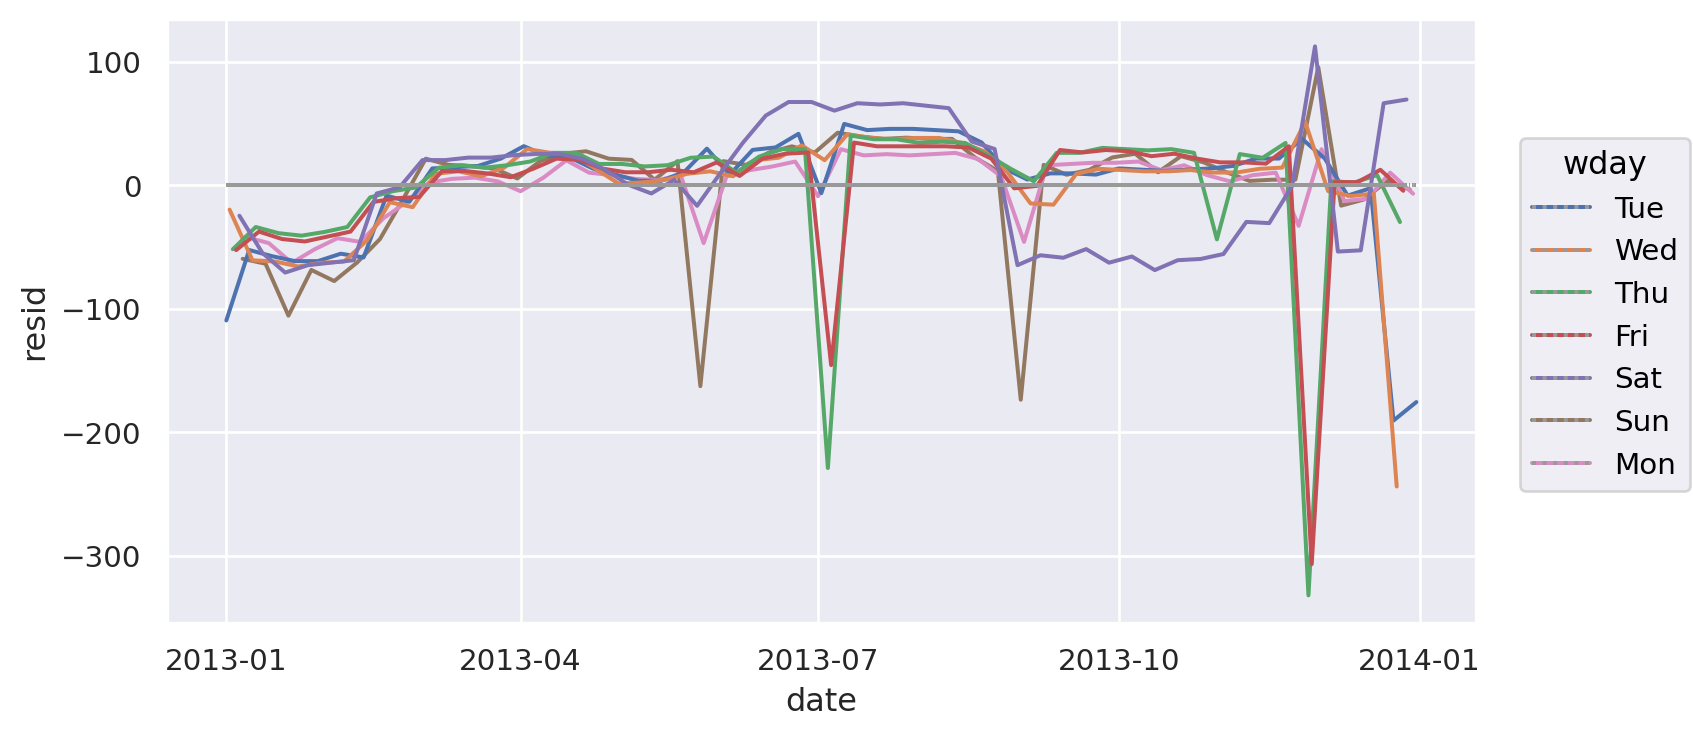

In [ ]:
(
    so.Plot(daily, x='date', y='resid', color="wday")
    .add(so.Line())
    .add(so.Line(color=".6", linestyle=":"), so.Agg(lambda x: 0))
    .layout(size=(8, 4))
)

# 확인해보니 토요일 패턴을 잘 잡아내지 못함

In [ ]:
# 적은 날 확인
daily.query('resid < -100')

,date,n,wday,resid
0,2013-01-01,842,Tue,-109.36
19,2013-01-20,786,Sun,-105.48
145,2013-05-26,729,Sun,-162.48
...,...,...,...,...
357,2013-12-24,761,Tue,-190.36
358,2013-12-25,719,Wed,-243.69
364,2013-12-31,776,Tue,-175.36


# natural spline으로 fit하기

In [ ]:
# 일년 중 몇 일째인지 수치형 변수로 추가: cr함수가 datetime을 처리하지 못함.
daily["day"] = daily["date"].dt.day_of_year

In [ ]:
# 10개의 조각으로 이루어진 cubic(3차) natural spline
fit_spline = smf.ols("resid ~ cr(day, df=10)", data=daily).fit()
daily["ns_fitted"] = fit_spline.fittedvalues

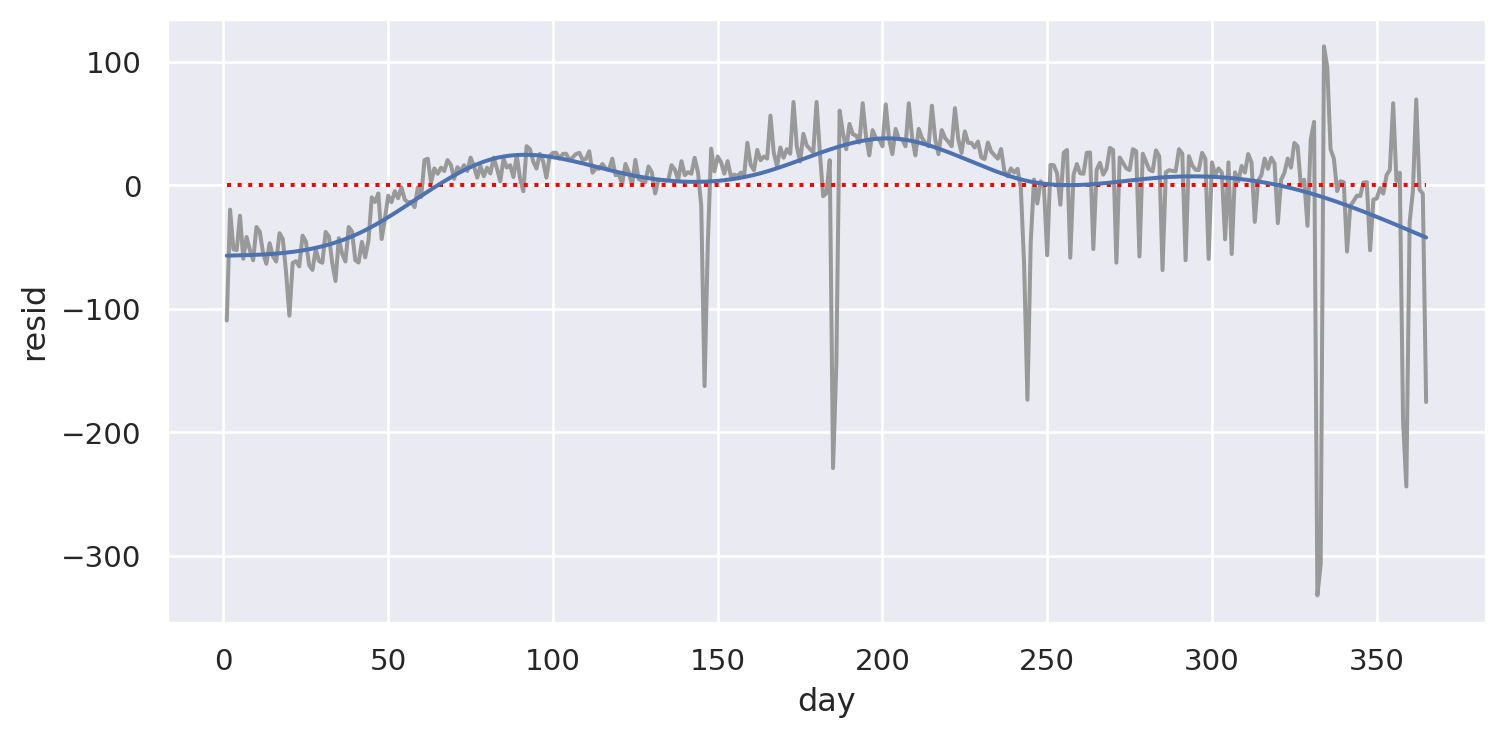

In [ ]:
p = (
    so.Plot(daily, x='day', y='resid')
    .add(so.Line(color=".6"))
    .add(so.Line(color="red", linestyle=":"), so.Agg(lambda x: 0))
    .add(so.Line(), y=daily.ns_fitted)  # predicted line by natural spline model
    .layout(size=(8, 4))
)
p

# 계절의 효과 살펴보기
## 앞서 말한 살펴볼 3가지 중에 첫번째 부분, 즉 토요일에 대해 나타나는 패턴을 잡아내기 위해

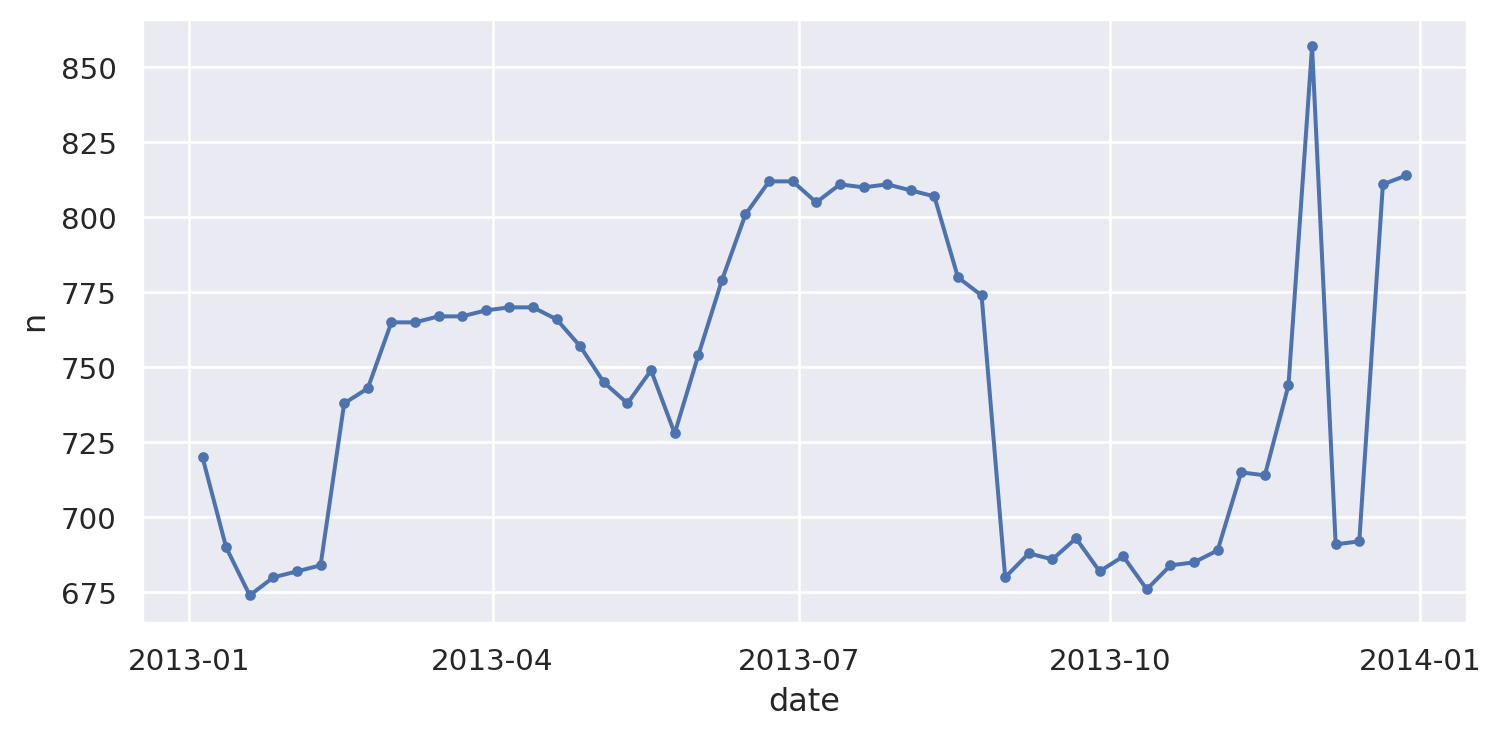

In [ ]:
(
    so.Plot(daily.query('wday == "Sat"'), x='date', y='n')
    .add(so.Line(marker="."))
    .layout(size=(8, 4))
)

# 여름에는 토요일에 여행하는 걸 마다하지 않는 것은 아마도 여름 방학이나 휴가철이라 그런 것일 듯,
# 가을에 토요일 항공편이 적은 것은 미국에서는 추수감사절이나 크리스마스와 같은 큰 공휴일들이 있어 가족여행을 계획하지 않는다고 하는데 추측해 볼 뿐임.

## cut 함수 사용해서 계절 나누기

In [ ]:
dates_cut = pd.to_datetime(["2013-01-01", "2013-06-05", "2013-08-25", "2014-01-01"])

# cut의 나눌 위치를 직접 지정
daily["term"] = pd.cut(
    daily["date"], dates_cut, right=False, labels=["spring", "summer", "fall"]
)

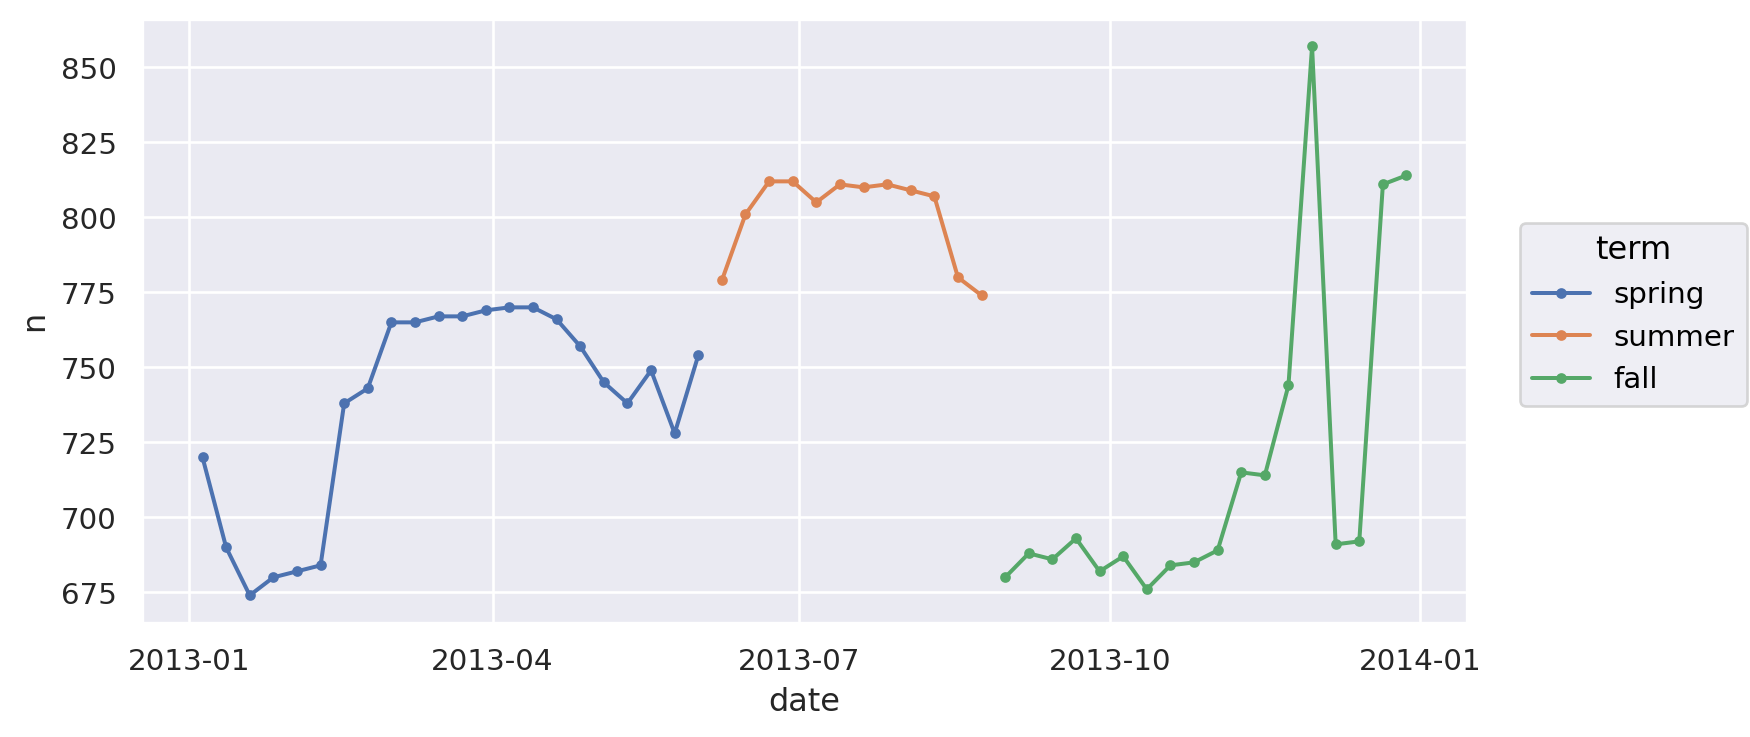

In [ ]:
(
    so.Plot(daily.query('wday == "Sat"'), x='date', y='n', color="term")
    .add(so.Line(marker="."))
    .layout(size=(8, 4))
)

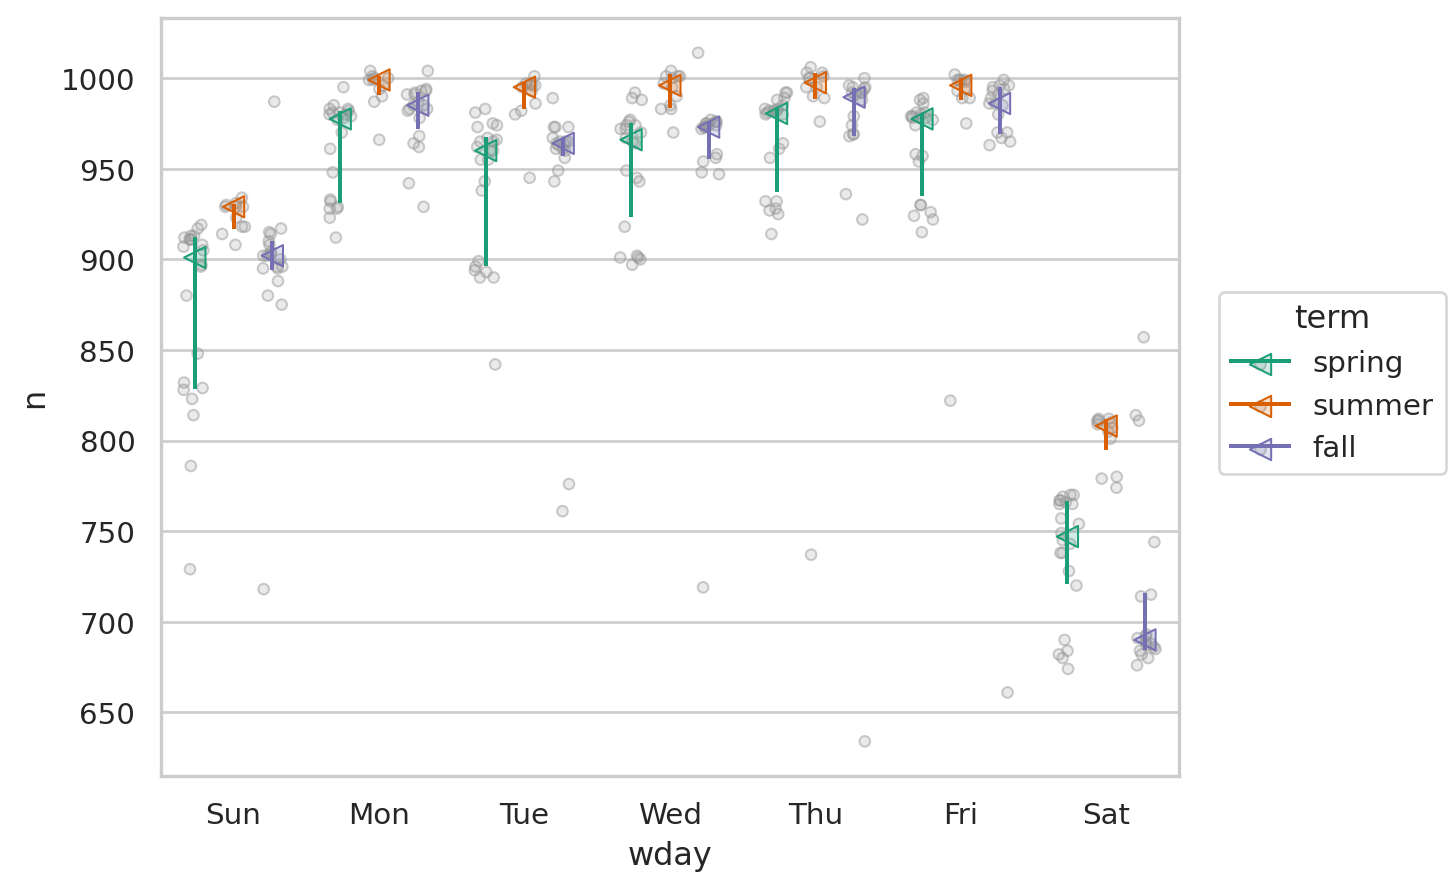

In [ ]:
boxplot(daily, x="wday", y="n", color="term", alpha=.5)
# 3개의 term에 따라 각 요일에서의 항공편의 개수가 큰 차이가 나는 것으로 보이며, 그 패턴이 요일마다 다른 것으로 보이므로, 각 term에 따라 요일의 효과를 분리해서 보는 것이 타당해보임.

# 모델 비교하기
# 요일로만 예측하는 모델 (mod1)과
# 요일과 term, 그리고 그 둘의 상호작용을 함께 고려한 모델 (mod2)을 세워 비교

In [ ]:
mod1 = smf.ols("n ~ wday", data=daily).fit()  # 요일로만 예측
mod2 = smf.ols("n ~ wday * term", data=daily).fit()  # 요일과 term, 그리고 요일과 term의 interaction으로 예측

In [ ]:
from patsy import dmatrices
y, X = dmatrices("n ~ wday * term", data=daily, return_type="dataframe")
X.columns

Index(['Intercept', 'wday[T.Mon]', 'wday[T.Tue]', 'wday[T.Wed]', 'wday[T.Thu]',
       'wday[T.Fri]', 'wday[T.Sat]', 'term[T.summer]', 'term[T.fall]',
       'wday[T.Mon]:term[T.summer]', 'wday[T.Tue]:term[T.summer]',
       'wday[T.Wed]:term[T.summer]', 'wday[T.Thu]:term[T.summer]',
       'wday[T.Fri]:term[T.summer]', 'wday[T.Sat]:term[T.summer]',
       'wday[T.Mon]:term[T.fall]', 'wday[T.Tue]:term[T.fall]',
       'wday[T.Wed]:term[T.fall]', 'wday[T.Thu]:term[T.fall]',
       'wday[T.Fri]:term[T.fall]', 'wday[T.Sat]:term[T.fall]'],
      dtype='object')

## melt 함수 사용해서 long format 만들기

In [ ]:
daily = daily.assign(
    without_term = mod1.resid,
    with_term = mod2.resid,
)

In [ ]:
daily_models = daily.melt(id_vars=["date"], value_vars=["without_term", "with_term"], var_name="model", value_name="residual")

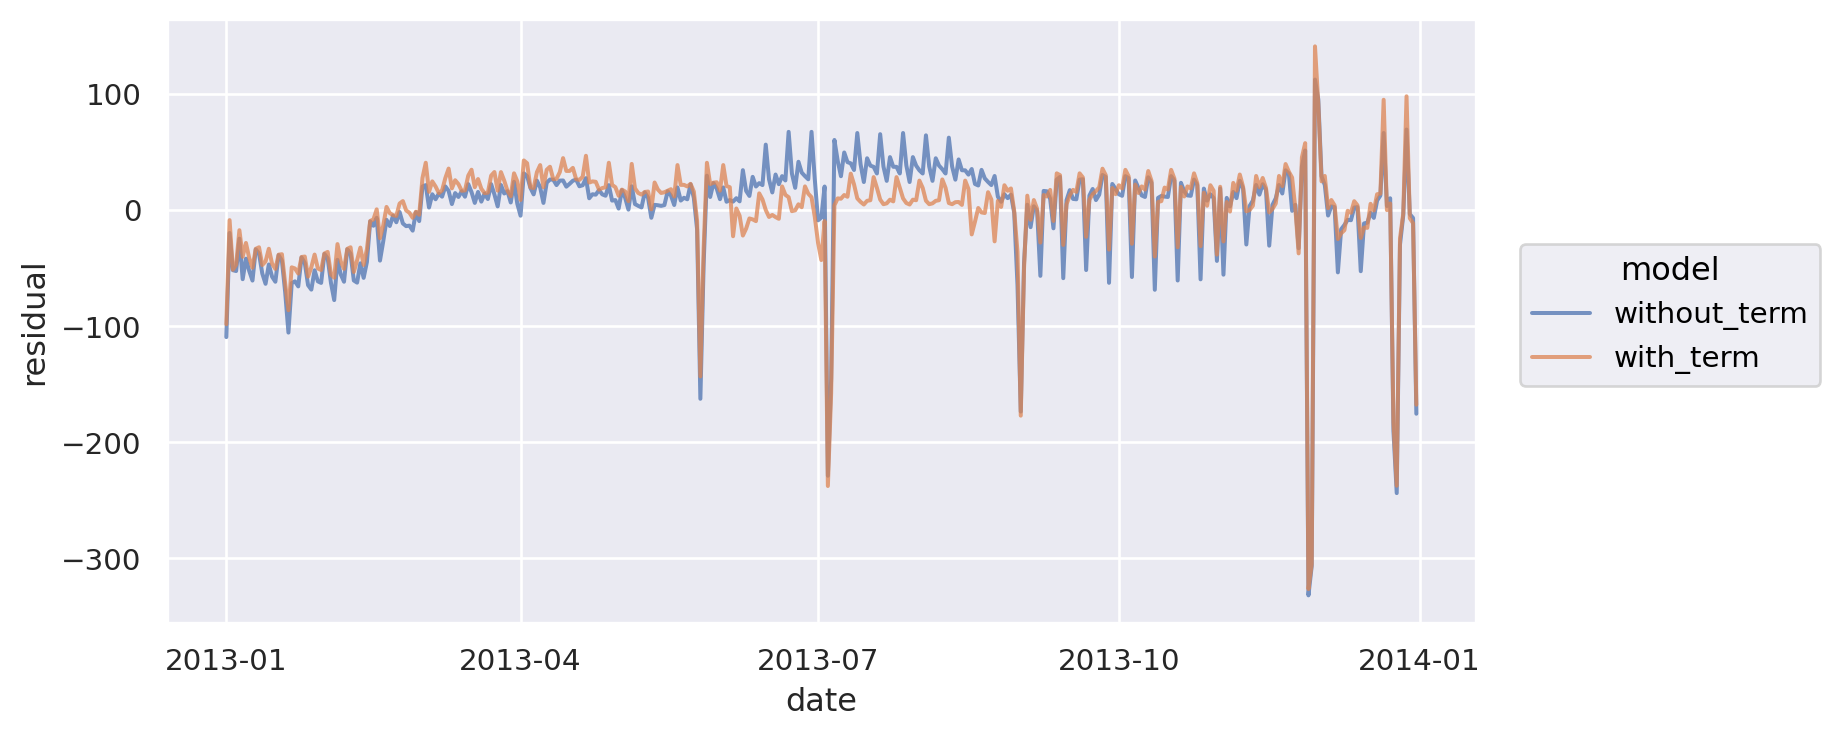

In [ ]:
(
    so.Plot(daily_models, x='date', y='residual', color="model")
    .add(so.Line(alpha=.75))
    .layout(size=(8, 4))
)

## 노가다로 grid 만들어주기

In [ ]:
wday_grid = ["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"]
term_grid = ["spring", "summer", "fall"]

# make a grid of wday and term
from itertools import product
grid = pd.DataFrame(
    list(product(wday_grid, term_grid)),
    columns=["wday", "term"],
)
grid

,wday,term
0,Sun,spring
1,Sun,summer
2,Sun,fall
...,...,...
18,Sat,spring
19,Sat,summer
20,Sat,fall


In [ ]:
grid["pred_mod2"] = mod2.predict(grid[["wday", "term"]])
grid

,wday,term,pred_mod2
0,Sun,spring,872.23
1,Sun,summer,923.91
2,Sun,fall,895.00
...,...,...,...
18,Sat,spring,737.32
19,Sat,summer,800.92
20,Sat,fall,716.00


In [ ]:
daily_plot = daily.merge(grid)
daily_plot

,date,n,wday,resid,day,ns_fitted,term,without_term,with_term,pred_mod2
0,2013-01-01,842,Tue,-109.36,1,-56.91,spring,-109.36,-98.26,940.26
1,2013-01-08,899,Tue,-52.36,8,-56.45,spring,-52.36,-41.26,940.26
2,2013-01-15,894,Tue,-57.36,15,-55.48,spring,-57.36,-46.26,940.26
...,...,...,...,...,...,...,...,...,...,...
362,2013-12-14,692,Sat,-52.62,348,-23.39,fall,-52.62,-24.00,716.00
363,2013-12-21,811,Sat,66.38,355,-30.97,fall,66.38,95.00,716.00
364,2013-12-28,814,Sat,69.38,362,-38.83,fall,69.38,98.00,716.00


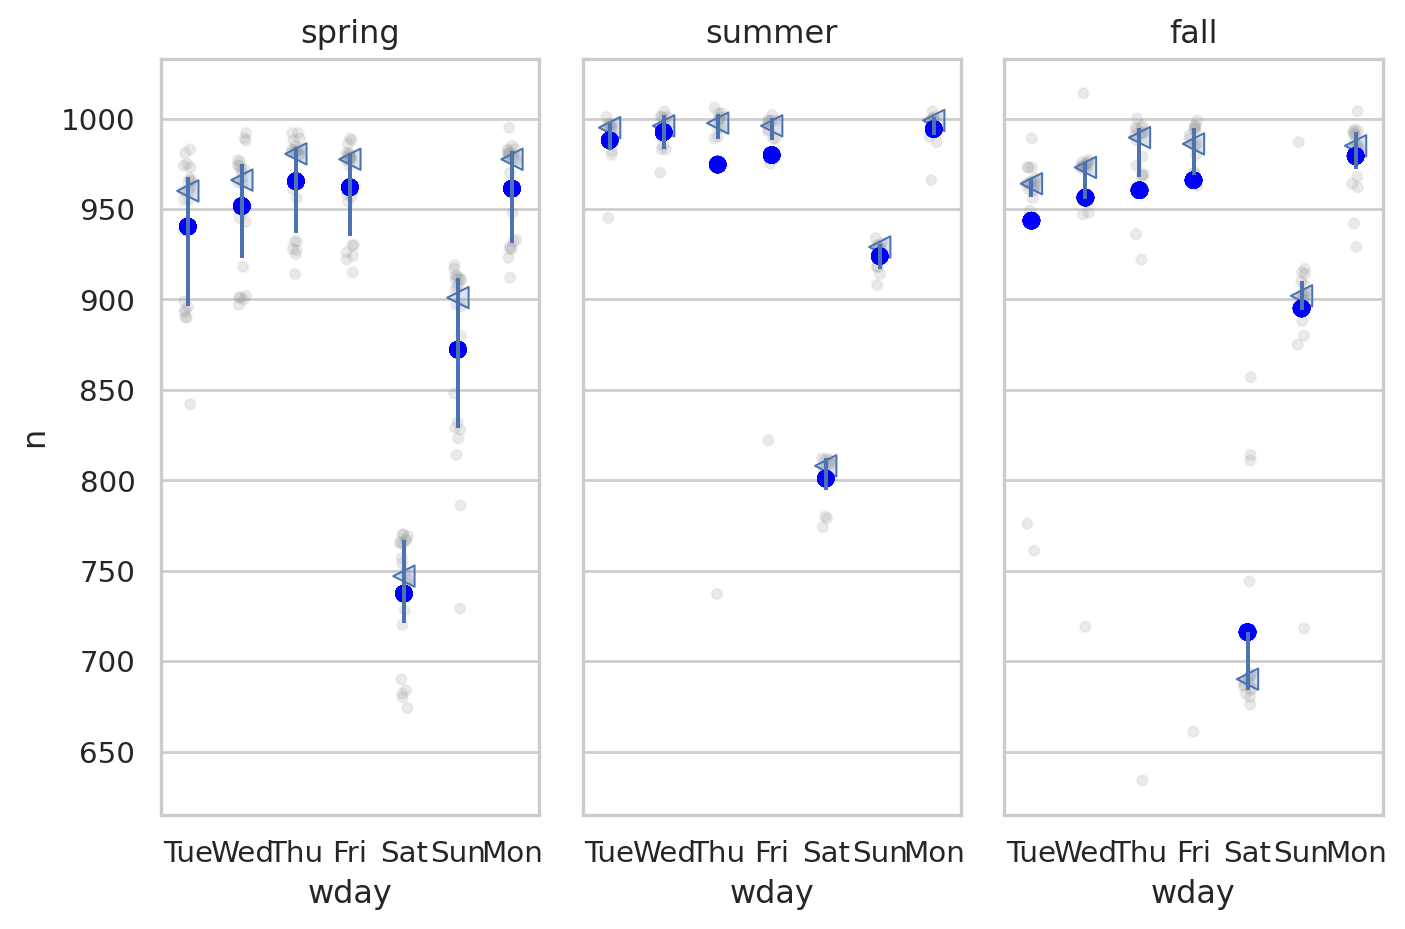

In [ ]:
(
    boxplot(daily_plot, x="wday", y="n")
    .add(so.Dot(color="blue"), y="pred_mod2")  # prediction 값을 추가
    .facet("term")
    .layout(size=(7.5, 5))
)

# robust regression 모형 mod3

In [ ]:
# Robust Linear Model (RLM) in statsmodels
mod3 = sm.RLM.from_formula("n ~ wday * term", data=daily).fit()

In [ ]:
## Predictions
# mod2: smf.ols("n ~ wday * term", data=daily)
grid["with_term_ols"] = mod2.predict(grid[["wday", "term"]])

# mod3: robust mod2
grid["with_term_rlm"] = mod3.predict(grid[["wday", "term"]])

In [ ]:
# Median 값 추가
daily_median = daily.groupby(["wday", "term"])["n"].median().reset_index(name="median")

In [ ]:
grid = grid.merge(daily_median, on=["wday", "term"])
grid

,wday,term,pred_mod2,with_term_ols,with_term_rlm,median
0,Sun,spring,872.23,872.23,893.50,901.00
1,Sun,summer,923.91,923.91,923.91,929.00
2,Sun,fall,895.00,895.00,900.09,902.00
...,...,...,...,...,...,...
18,Sat,spring,737.32,737.32,746.82,747.00
19,Sat,summer,800.92,800.92,801.22,808.00
20,Sat,fall,716.00,716.00,696.90,690.00


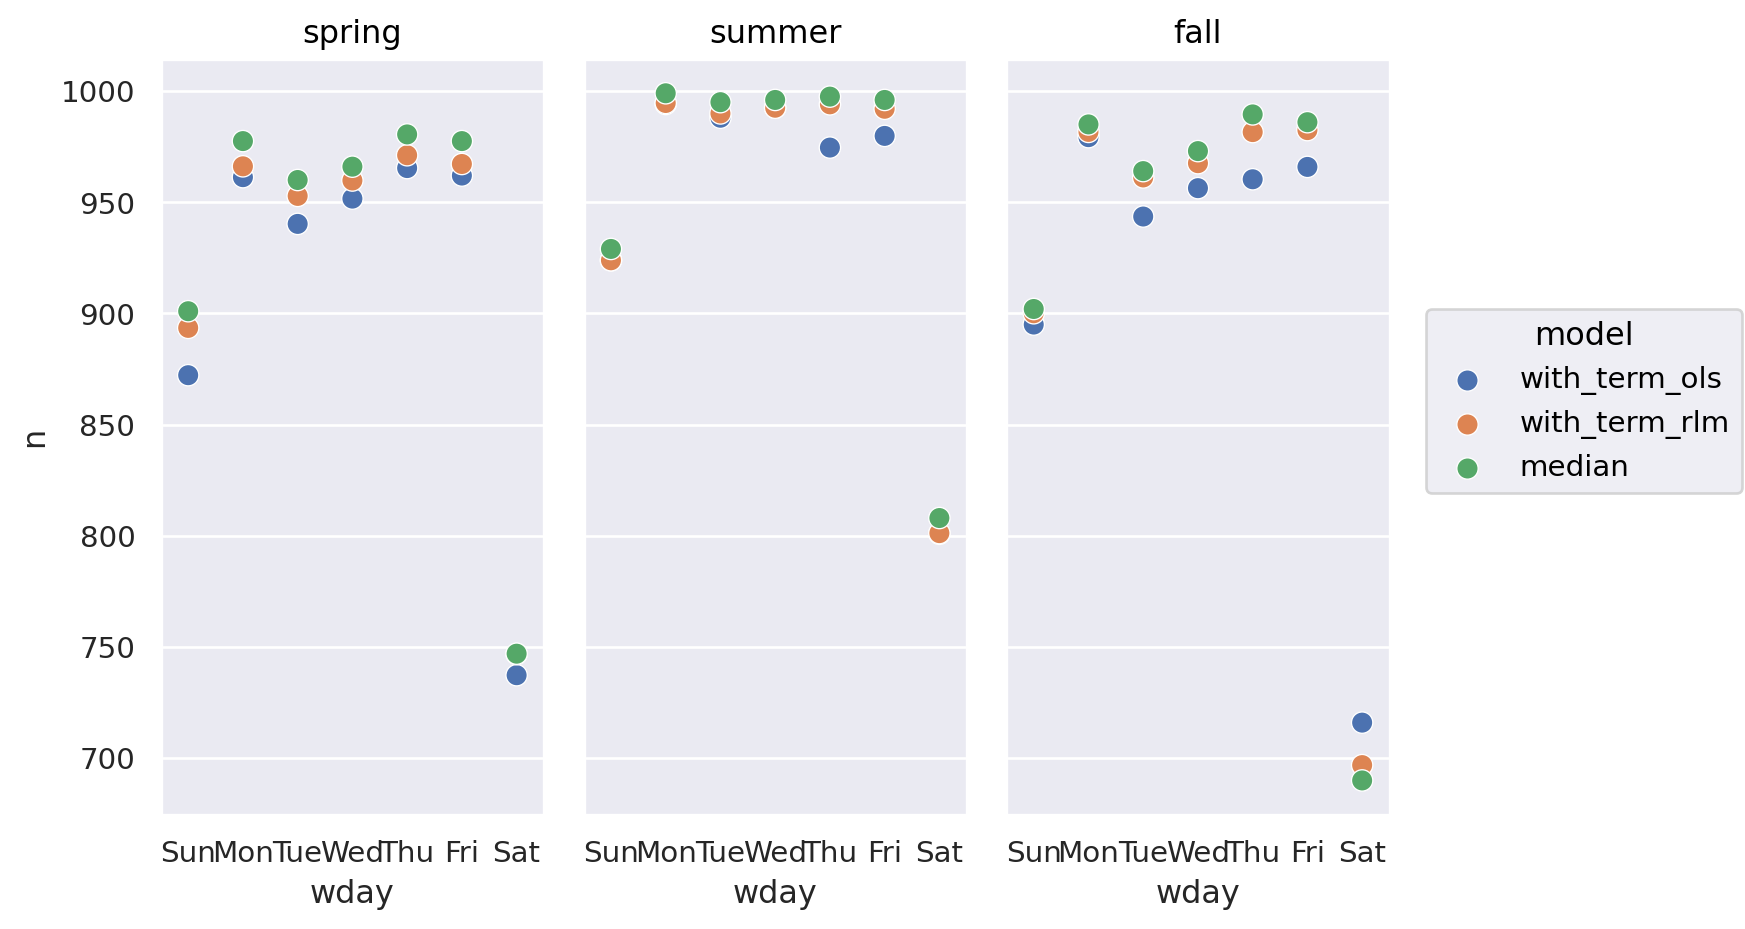

In [ ]:
grid_long = grid.melt(id_vars=["wday", "term"], value_vars=["with_term_ols", "with_term_rlm", "median"], var_name="model", value_name="n")

(
    so.Plot(grid_long, x='wday', y='n', color="model")
    .add(so.Dot(edgecolor="w", pointsize=8))
    .facet("term")
    .layout(size=(7.5, 5))
)

In [ ]:
mod3.params

Intercept                  893.50
wday[T.Mon]                 72.65
wday[T.Tue]                 59.34
                            ...  
wday[T.Thu]:term[T.fall]     3.82
wday[T.Fri]:term[T.fall]     8.65
wday[T.Sat]:term[T.fall]   -56.51
Length: 21, dtype: float64

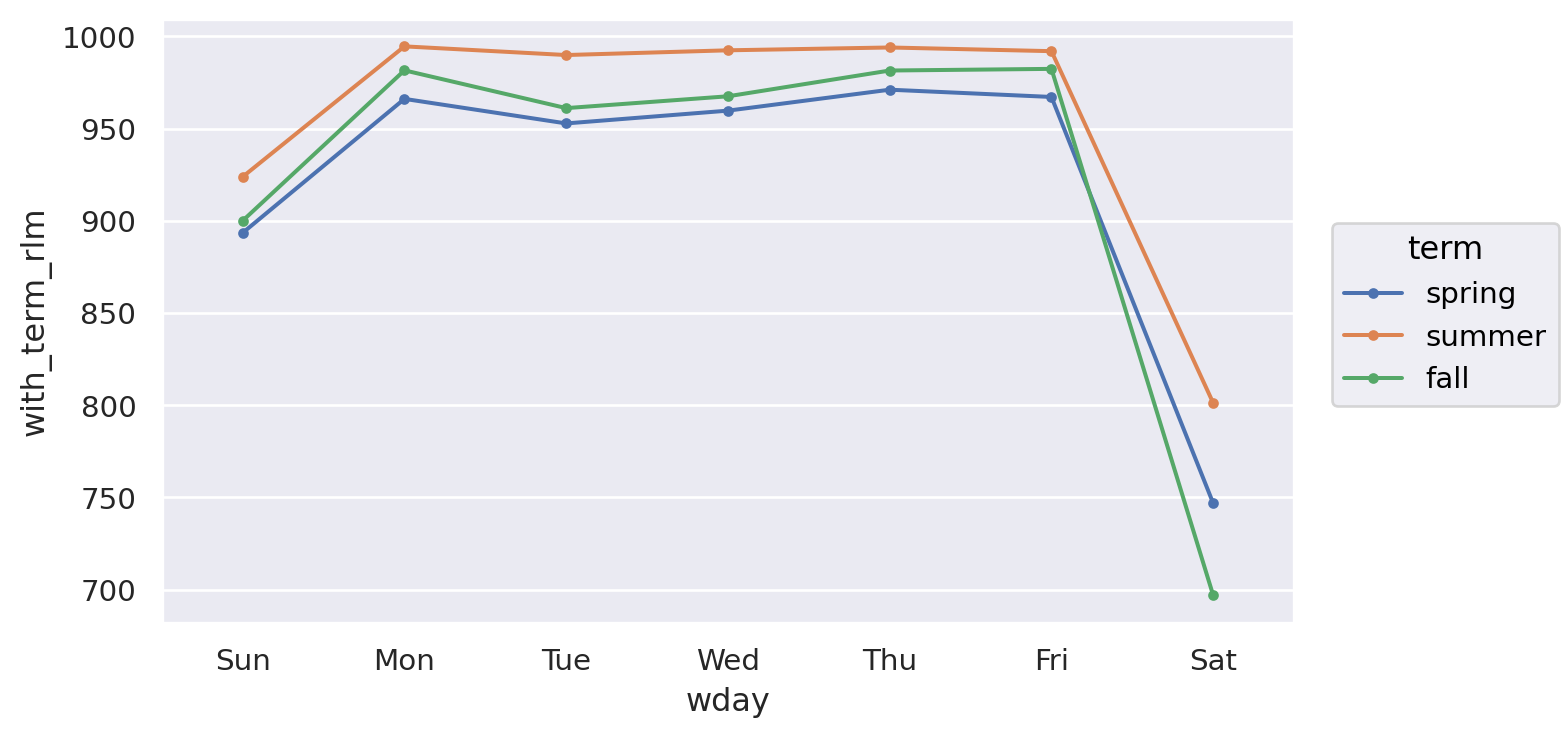

In [ ]:
(
    so.Plot(grid, x='wday', y='with_term_rlm', color="term")
    .add(so.Line(marker="."))
    .layout(size=(7, 4))
)

## 잔차 보기

In [ ]:
daily["with_term_rlm"] = mod3.resid

In [ ]:
daily_models = daily.melt(
    id_vars=["date"],
    value_vars=["with_term", "with_term_rlm"],
    var_name="model",
    value_name="residual",
)

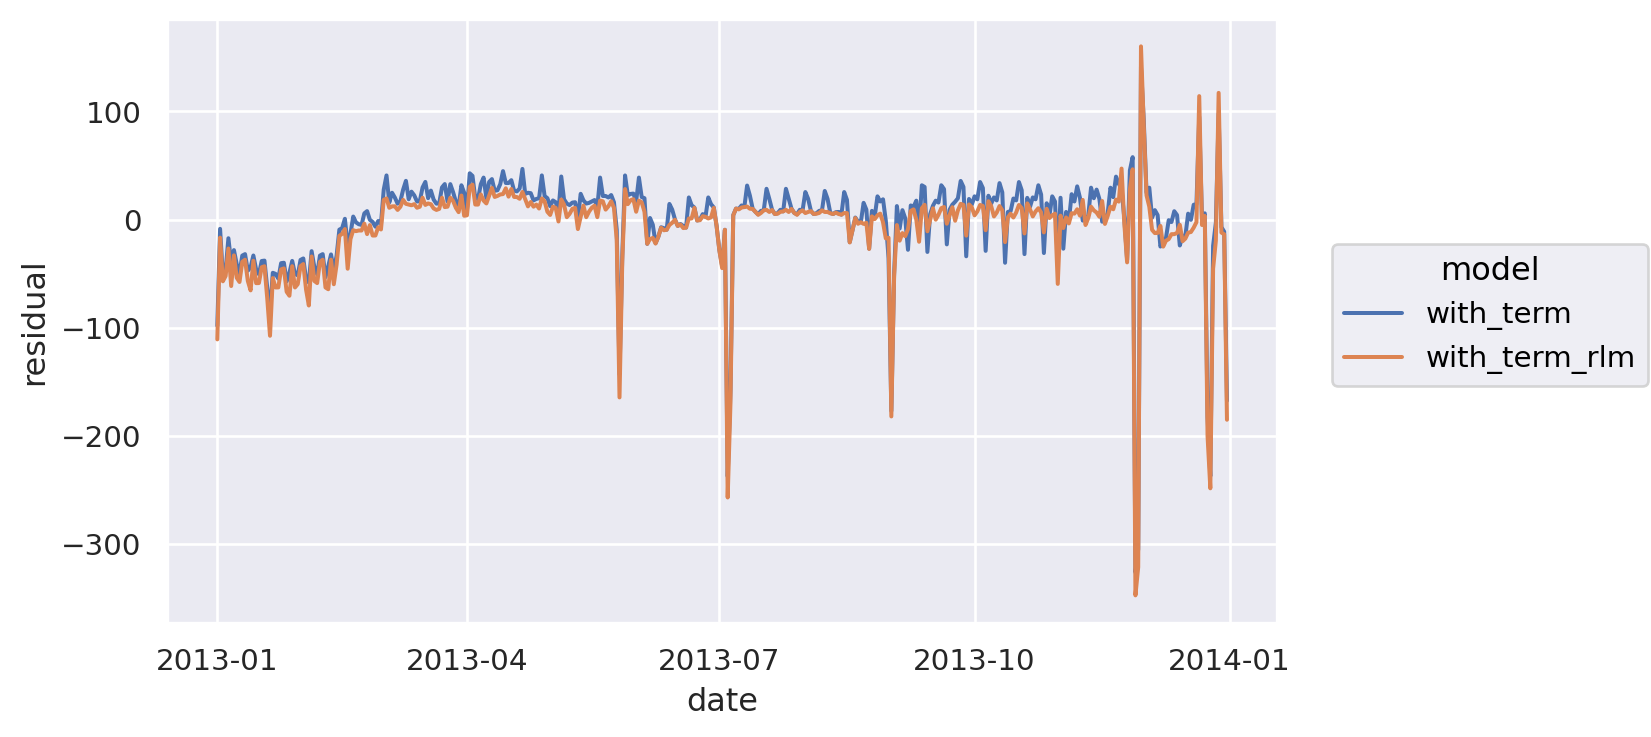

In [ ]:
(
    so.Plot(daily_models, x='date', y='residual', color="model")
    .add(so.Line())
    .layout(size=(7, 4))
)